In [1]:
%matplotlib inline
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import collections
from tqdm.auto import tqdm
from tensorboardX import SummaryWriter

import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [4]:
from src.data.gp_curves import GPCurvesReader
from src.models.model import LatentModel

## Util

In [5]:
def set_seed(n=42):
    np.random.seed(n)
    torch.manual_seed(n)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

In [6]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std):
    """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape [B,num_targets,1] that contains the
        x values of the target points.
    target_y: An array of shape [B,num_targets,1] that contains the
        y values of the target points.
    context_x: An array of shape [B,num_contexts,1] that contains 
        the x values of the context points.
    context_y: An array of shape [B,num_contexts,1] that contains 
        the y values of the context points.
    pred_y: An array of shape [B,num_targets,1] that contains the
        predicted means of the y values at the target points in target_x.
    std: An array of shape [B,num_targets,1] that contains the
        predicted std dev of the y values at the target points in target_x.
      """
    # Plot everything
    plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
    plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
    plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
    plt.fill_between(
          target_x[0, :, 0],
          pred_y[0, :, 0] - std[0, :, 0],
          pred_y[0, :, 0] + std[0, :, 0],
          alpha=0.25,
          facecolor='blue',
          interpolate=True)

    # Make the plot pretty
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-2, 2])
    plt.grid('off')
    ax = plt.gca()

In [7]:
def test(model, dataset_test, writer=None, plot=False, global_step=None, seed=42, title=''):
    model.eval()
    with torch.no_grad():
        data_test = dataset_test.generate_curves()

        (context_x, context_y), target_x = data_test.query
        target_y = data_test.target_y

        context_x = context_x.cuda()
        context_y = context_y.cuda()
        target_x = target_x.cuda()
        target_y = target_y.cuda()

        y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x, target_y)

        # Lets order the result, for plotting
        target_inds = torch.argsort(target_x[0, :, 0])
        target_x = target_x[:, target_inds, :]
        target_y = target_y[:, target_inds, :]
        context_inds = torch.argsort(context_x[0, :, 0])
        context_y = context_y[:, context_inds, :]
        context_x = context_x[:, context_inds, :]
        y_pred = y_pred[:, target_inds, :]
        y_std = y_std[:, target_inds, :]
        
        if writer is not None:
            writer.add_scalar('val/loss', loss, global_step=global_step)
            writer.add_scalar('val/y_std', y_std.mean(), global_step=global_step)
            writer.add_scalar('val/mse_loss', mse_loss, global_step=global_step)
            writer.add_scalar('val/kl', kl.mean(), global_step=global_step)
        
        if plot:
            set_seed(seed)
            fig = plt.figure()
            plt.title(f"{title}. Iter {global_step}")            
            plot_functions(target_x.detach().cpu().numpy(),
                           target_y.detach().cpu().numpy(),
                           context_x.detach().cpu().numpy(),
                           context_y.detach().cpu().numpy(),
                           y_pred.detach().cpu().numpy(),
                           y_std.detach().cpu().numpy())
            
            writer.add_figure('test', fig, global_step=global_step, close=False)
            plt.show()
            
    return y_pred, kl, loss, y_std

In [8]:
def evaluate(model, dataset_test, n=100):
    return torch.stack([
        test(model, dataset_test)[2] for _ in tqdm(range(n))
    ]).mean().cpu()

# Init

In [9]:
MAX_CONTEXT_POINTS = 50
random_kernel_parameters = True

dataset_train = GPCurvesReader(
    batch_size=16,
    max_num_context=MAX_CONTEXT_POINTS,
    random_kernel_parameters=random_kernel_parameters,
    sequential=True,
)

dataset_test = GPCurvesReader(
    batch_size=1,
    max_num_context=MAX_CONTEXT_POINTS,
    testing=True,
    random_kernel_parameters=random_kernel_parameters,
    sequential=True,
)

## Replicate ANP paper

In [10]:
epochs = 100000
PLOT_AFTER = sorted(set([100, 200, 400, 1000, 2000, 4000, 8000] + list(range(0, epochs+1, 10000))))
PRINT_AFTER = 1000

runs/Feb15_15-25-36_mjcdesktop-anp-rnn_1d_reg



train: 0 loss= 1.194 val_loss= 0.9067


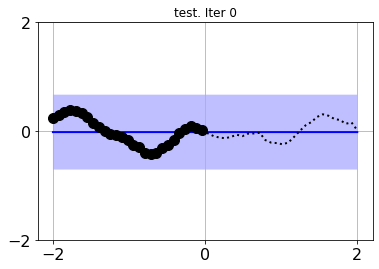

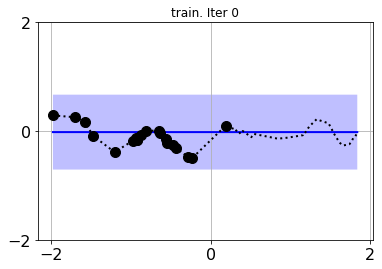

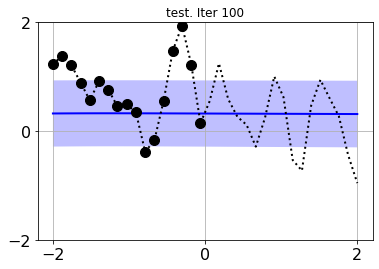

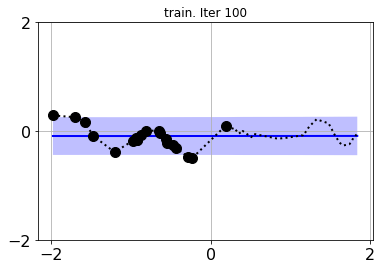

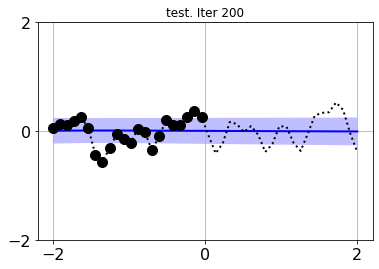

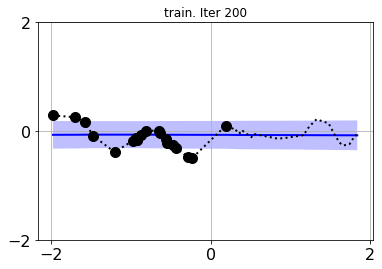

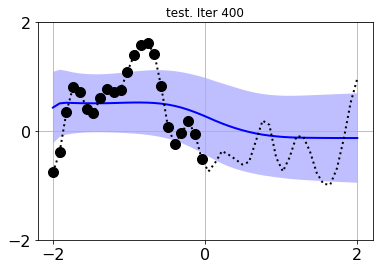

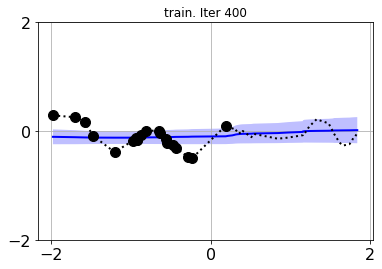


train: 1000 loss= 0.06843 val_loss= 0.3942


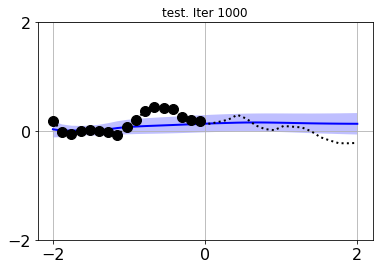

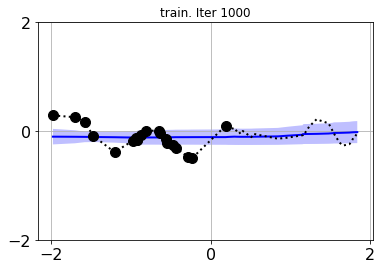


train: 2000 loss=-0.23 val_loss=-0.04989


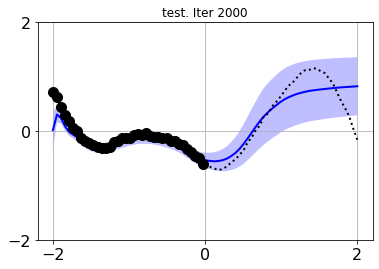

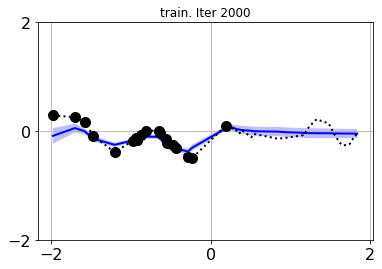


train: 3000 loss=-0.8103 val_loss=-0.1836



train: 4000 loss=-0.8786 val_loss=-0.2029


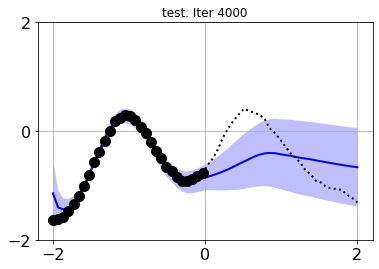

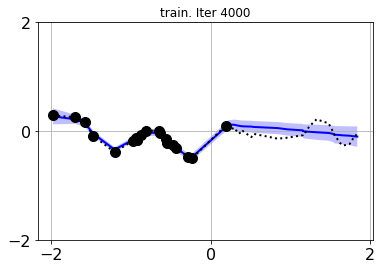


train: 5000 loss=-0.8079 val_loss= 0.0879



train: 6000 loss=-0.5261 val_loss=-0.1047



train: 7000 loss=-1.203 val_loss=-0.3966



train: 8000 loss=-1.306 val_loss=-0.5159


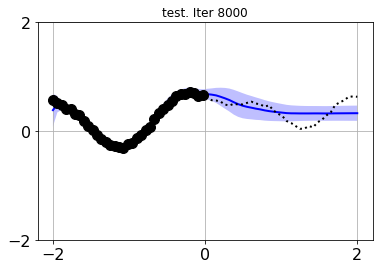

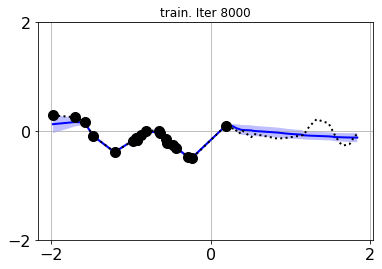


train: 9000 loss=-0.003201 val_loss= 0.3222



train: 10000 loss= 0.1244 val_loss= 0.3631


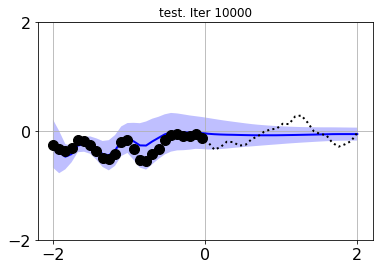

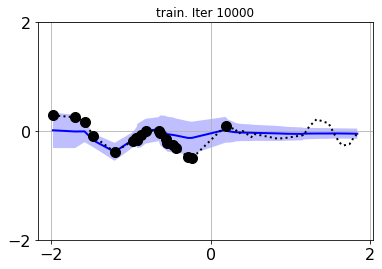


train: 11000 loss=-1.856 val_loss=-0.5413



train: 12000 loss=-0.4814 val_loss=-0.6354


In [ ]:


writer = SummaryWriter(comment='-anp-rnn_1d_reg')
print(writer.logdir)

hparams = dict(
    x_dim=1,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="uniform",
    det_enc_self_attn_type="uniform",
    det_enc_cross_attn_type="multihead",
    use_rnn=True)
model = LatentModel(**hparams).cuda()

optim = torch.optim.Adam(model.parameters(), lr=1e-4)

for n_iter in tqdm(range(epochs)):
    model.train()

    data_train = dataset_train.generate_curves()

    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y

    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    optim.zero_grad()
    y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,
                                              target_y)
    loss.backward()
    optim.step()

    writer.add_scalar('train/loss', loss, n_iter)
    writer.add_scalar('train/mse_loss', mse_loss, n_iter)
    writer.add_scalar('train/y_std', y_std.mean(), n_iter)
    writer.add_scalar('train/kl', kl.mean(), n_iter)

    if n_iter % PRINT_AFTER == 0:
        y_pred, kl, val_loss, y_std = test(
            model, dataset_test, writer, plot=False, global_step=n_iter)
        val_loss = evaluate(model, dataset_test, 100)
        writer.add_scalar('val/loss_mean', val_loss, n_iter)
        print(
            f"train: {n_iter} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
        )

    if n_iter in PLOT_AFTER:
        test(model, dataset_test, writer, plot=True, global_step=n_iter, title='test')
        
        test(model, dataset_train, writer, plot=True, global_step=n_iter, seed=n_iter, title='train')
        
    # Final validation
val_loss = evaluate(model, dataset_test, 300)
print('val loss (n=300)', loss)
writer.add_hparams(hparams, dict(val_loss=loss))

for i in range(3):
    set_seed(i)
    test(model, dataset_test, writer, plot=True, global_step=-1, seed=i, title='test_final')
    
for i in range(3):
    test(model, dataset_train, writer, plot=True, global_step=-1, seed=i, title='train_final')

## Improved

These have no been extensively tested:

- use torches ~50% faster multiheaded attention
- calc loss in log domain for stability (and untested changes to clipping)
- dropout

In [ ]:
writer = SummaryWriter(comment='-anp-rnn_1d_impr')
print(writer.logdir)
                 
hparams = dict(
    x_dim=1,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="ptmultihead",
    det_enc_self_attn_type="ptmultihead",
    det_enc_cross_attn_type="ptmultihead",
    use_rnn=True,
    min_std=1e-3,
    use_lvar=True,
    use_self_attn=True,
    attention_dropout=0.3,
    dropout=0.3,
#     batchnorm=True,
)
model = LatentModel(**hparams).cuda()

optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

for n_iter in tqdm(range(epochs)):
    model.train()

    data_train = dataset_train.generate_curves()

    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y

    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    optim.zero_grad()
    y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,
                                              target_y)
    loss.backward()
    optim.step()

    writer.add_scalar('train/loss', loss, n_iter)
    writer.add_scalar('train/mse_loss', mse_loss, n_iter)
    writer.add_scalar('train/y_std', y_std.mean(), n_iter)
    writer.add_scalar('train/kl', kl.mean(), n_iter)

    if n_iter % PRINT_AFTER == 0:
        y_pred, kl, val_loss, y_std = test(
            model, dataset_test, writer, plot=False, global_step=n_iter)
        val_loss = evaluate(model, dataset_test, 100)
        writer.add_scalar('val/loss_mean', val_loss, n_iter)
        print(
            f"train: {n_iter} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
        )

    if n_iter in PLOT_AFTER:
        test(model, dataset_test, writer, plot=True, global_step=n_iter, title='test')
        
        test(model, dataset_train, writer, plot=True, global_step=n_iter, seed=n_iter, title='train')
        
    # Final validation
val_loss = evaluate(model, dataset_test, 300)
print('val loss (n=300)', loss)
writer.add_hparams(hparams, dict(val_loss=loss))

for i in range(3):
    set_seed(i)
    test(model, dataset_test, writer, plot=True, global_step=-1, seed=i, title='test_final')
    
for i in range(3):
    test(model, dataset_train, writer, plot=True, global_step=-1, seed=i, title='train_final')

# ANP

In [ ]:
writer = SummaryWriter(comment='-anp_1d')
print(writer.logdir)
                 
hparams = dict(
    x_dim=1,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="multihead",
    det_enc_self_attn_type="multihead",
    det_enc_cross_attn_type="multihead",
    use_rnn=False)
model = LatentModel(**hparams).cuda()

optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

for n_iter in tqdm(range(epochs)):
    model.train()

    data_train = dataset_train.generate_curves()

    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y

    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    optim.zero_grad()
    y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,
                                              target_y)
    loss.backward()
    optim.step()

    writer.add_scalar('train/loss', loss, n_iter)
    writer.add_scalar('train/mse_loss', mse_loss, n_iter)
    writer.add_scalar('train/y_std', y_std.mean(), n_iter)
    writer.add_scalar('train/kl', kl.mean(), n_iter)

    if n_iter % PRINT_AFTER == 0:
        y_pred, kl, val_loss, y_std = test(
            model, dataset_test, writer, plot=False, global_step=n_iter)
        val_loss = evaluate(model, dataset_test, 100)
        writer.add_scalar('val/loss_mean', val_loss, n_iter)
        print(
            f"train: {n_iter} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
        )

    if n_iter in PLOT_AFTER:
        test(model, dataset_test, writer, plot=True, global_step=n_iter, title='test')
        
        test(model, dataset_train, writer, plot=True, global_step=n_iter, seed=n_iter, title='train')
        
    # Final validation
val_loss = evaluate(model, dataset_test, 300)
print('val loss (n=300)', loss)
writer.add_hparams(hparams, dict(val_loss=loss))

for i in range(3):
    set_seed(i)
    test(model, dataset_test, writer, plot=True, global_step=-1, seed=i, title='test_final')
    
for i in range(3):
    test(model, dataset_train, writer, plot=True, global_step=-1, seed=i, title='train_final')

# NP

In [ ]:
writer = SummaryWriter(comment='-np_1d')
print(writer.logdir)
                 
hparams = dict(
    x_dim=1,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="uniform",
    det_enc_self_attn_type="uniform",
    det_enc_cross_attn_type="uniform",
    use_rnn=False)
model = LatentModel(**hparams).cuda()

optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

for n_iter in tqdm(range(epochs)):
    model.train()

    data_train = dataset_train.generate_curves()

    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y

    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    optim.zero_grad()
    y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,
                                              target_y)
    loss.backward()
    optim.step()

    writer.add_scalar('train/loss', loss, n_iter)
    writer.add_scalar('train/mse_loss', mse_loss, n_iter)
    writer.add_scalar('train/y_std', y_std.mean(), n_iter)
    writer.add_scalar('train/kl', kl.mean(), n_iter)

    if n_iter in PLOT_AFTER:
        y_pred, kl, val_loss, y_std = test(
            model, dataset_test, writer, plot=False, global_step=n_iter)
        val_loss = evaluate(model, dataset_test, 100)
        writer.add_scalar('val/loss_mean', val_loss, n_iter)
        print(
            f"train: {n_iter} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
        )

    if n_iter % PLOT_AFTER == 0:
        test(model, dataset_test, writer, plot=True, global_step=n_iter, title='test')
        test(model, dataset_train, writer, plot=True, global_step=n_iter, seed=n_iter, title='train')